In [10]:
def bcctcoreClassifier (asyMeasDict, colScarMeasDict):
    
    feat0=asyMeasDict['pLBC']
    
    feat1=asyMeasDict['pBCE']
    
    
    try:
        feat2=colScarMeasDict['cChi2b']
    except Exception:
        print ('NO cChi2b')
        feat2=0
   
    
    features = [feat0, feat1, feat2]
    
    return scorecardPrediction(features)
    
def scorecardPrediction(features) :
    classes = ["UNKNOWN", "EXCELLENT", "GOOD", "FAIR", "POOR"]
    prediction = -1
    points = 0.0
    if (features[0]<0.0174):
        points = 0
    elif (features[0]<0.1012):
        points = 0.1538
    elif (features[0]<0.1707):
        points = 0.4379
    else:
        points = 0.5767

    if (features[1]<0.0184):
        points += 0
    elif (features[1]<0.3684):
        points += 0.0636
    elif (features[1]<0.9219):
        points += 0.1938
    else :
        points += 0.2128

    if (features[2]<0.0140):
        points += 0
    elif (features[2]<0.0267):
        points += 0.0299
    elif (features[2]<0.6881):
        points += 0.0642
    else:
        points += 0.0727

    if (points < 0.1738):
        prediction = 1
    elif (points<0.3720):
        prediction = 2
    elif (points<0.7002):
        prediction = 3
    else:
        prediction = 4
    return prediction, classes[prediction]


### use RiskSLIM on aesthetic data only with columns chosen by old scorecard

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from libraries.caimcaim import CAIMD
from sbc import SBC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from scorecard import Scorecard


# columns thresholds
pLBC_thresholds = [0.0174, 0.1012, 0.1707]
pBCE_thresholds = [0.0184, 0.3684, 0.9219]
cXb2_thresholds = [0.0140, 0.0267, 0.6881]
thresholds = {
    'pLBC Value': pLBC_thresholds,
    'pBCE Value': pBCE_thresholds,
    'cX2b Value': cXb2_thresholds,
    'sbcol1': [0.5],
    'sbcol2': [0.5]
}

# prediction thresholds
prediction_thresholds = [0.1738, 0.3720, 0.7002]



# load data
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')
aesthetic_evaluation_data = aesthetic_evaluation_data.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_X = aesthetic_evaluation_data.drop(columns='Subjective Evaluation')
#aesthetic_evaluation_X = aesthetic_evaluation_X[['pLBC Value', 'pBCE Value', 'cX2b Value', 'pUNR Value']]
aesthetic_evaluation_y = aesthetic_evaluation_data['Subjective Evaluation']
mapping = {4: 'Poor', 3: 'Fair', 2: 'Good', 1: 'Excellent'}
K = 4
ordinal = False

if not ordinal:
    aesthetic_evaluation_y = aesthetic_evaluation_y.map({'Poor':0, 'Fair':0, 'Good': 1, 'Excellent': 1})

# get train and test sets
train_X, test_X, train_y, test_y = train_test_split(aesthetic_evaluation_X, aesthetic_evaluation_y, test_size=0.25, random_state=42)
original_train_y = train_y.copy()
original_test_y = test_y.copy()

# do SBC
if ordinal:
    sbc = SBC()
    sbc_train_X, sbc_train_y = sbc.reduction(train_X, train_y, K, mapping)
    sbc_test_X, sbc_test_y = sbc.reduction(test_X, test_y, K, mapping)

    train_X = sbc_train_X.copy()
    test_X = sbc_test_X.copy()
    train_y = sbc_train_y.copy()
    test_y = sbc_test_y.copy()
    

# get encoded version of the data with differential coding
def disc_diff_coding(X, thresholds, categorical=[]):
    encoded_X = []
    for col in X.columns:
        if col not in thresholds.keys():
            continue  # skip columns not in thresholds
        if col in categorical:
            bin = pd.Categorical(X[col], categories=thresholds[col]).codes
            num_bins = len(thresholds[col])
        else:
            X_col_float = X[col].astype(float)
            bin = np.digitize(X_col_float, thresholds[col]) # gets bin number of each row
            num_bins = len(thresholds[col]) + 1
        
        bin_df = pd.DataFrame(0, index=X.index, columns=[f'feat{col}-bin{i}' for i in range(1, num_bins)])
        for i in range(1, num_bins):
            bin_df[f'feat{col}-bin{i}'] = (bin >= i).astype(int)
        
        encoded_X.append(bin_df)

    # concatenate all encoded columns
    encoded_X = pd.concat(encoded_X, axis=1)

    return encoded_X

# get caim thresholds
'''thresholds = {}
caim = CAIMD([])
if ordinal:
    # remove sbc column
    help_X = train_X.loc[:, ~train_X.columns.str.startswith('sbc')]
    train_X = help_X.copy()
caim.fit_transform(train_X, train_y)
index_non_categorical = [i for i in range(train_X.shape[1])]
thresholds = {train_X.columns[index_non_categorical[i]]: [float(val) for val in values] for i, (key, values) in enumerate(caim.split_scheme.items())}
if ordinal:
    # add sbc columns with threshold = 0.5
    for col in ['sbcol1', 'sbcol2']:
        thresholds[col] = [0.5]'''
        
# get infinitesimal bins thresholds
'''thresholds = {}
for col in train_X.columns:
    sorted_col = np.unique(train_X[col])
    sorted_col = sorted_col.astype(float)  # ensure the values are floats
    col_thresholds = (sorted_col[:-1] + sorted_col[1:]) / 2
    thresholds[col] = col_thresholds.tolist()'''


# encode the data
encoded_train_X = disc_diff_coding(train_X, thresholds)
encoded_test_X = disc_diff_coding(test_X, thresholds)

# add the target variable as the first column, and substitute 0 by -1
encoded_train_X.insert(0, 'target', train_y.replace({0: -1}))

# to csv
#encoded_train_X.to_csv('datasets/riskslim/aesthetic_inf_ordinal.csv', index=False)

encoded_train_X = encoded_train_X.drop(columns=['target'])

print(encoded_train_X.shape)

(1018, 9)


#### test existing thresholds on ordinal dataset

testing parameters: {'C': 0.0009765625}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.2200328407224959
testing parameters: {'C': 0.001953125}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.22101323287935865
testing parameters: {'C': 0.00390625}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.3948662223510094
testing parameters: {'C': 0.0078125}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.4872935381048972
testing parameters: {'C': 0.015625}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.4980826813484015
testing parameters: {'C': 0.03125}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.49611223799864773
testing parameters: {'C': 0.0625}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.49611223799864773
testing parameters: {'C': 0.125}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5649666763257026
testing parameters: {'C': 0.25}
  fold  1

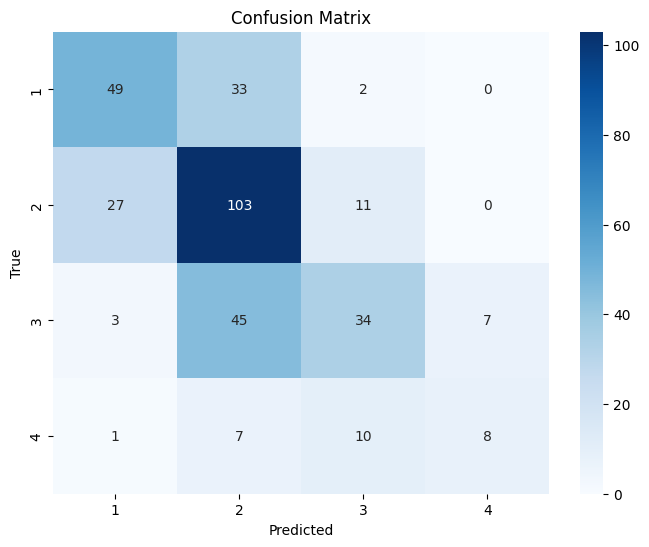

accuracy for class 1: 0.583
accuracy for class 2: 0.730
accuracy for class 3: 0.382
accuracy for class 4: 0.308

Evaluating the model on the train set...
accuracy on train set:  0.5952848722986247
precision on train set:  0.6043561279987707
recall on train set:  0.5952848722986247
f1 score on train set:  0.5827621536923672
balanced accuracy on train set:  0.534409077547192
logistic loss on train set:  0.05022302955555934
mse on train set:  0.47053045186640474

Scorecard table:
      Feature               Bin    Points
0  pLBC Value  [0.0174, 0.1012[  1.999582
1  pLBC Value  [0.1012, 0.1707[  1.999630
2  pLBC Value     [0.1707, inf[  2.000000
3  pBCE Value  [0.0184, 0.3684[  0.000204
4  pBCE Value  [0.3684, 0.9219[  1.999510
5  pBCE Value     [0.9219, inf[  0.000763
6  cX2b Value   [0.014, 0.0267[ -0.000205
7  cX2b Value  [0.0267, 0.6881[ -0.000191
8  cX2b Value     [0.6881, inf[  1.999046

SBC columns weights:
            Feature    Weight
9   featsbcol1-bin1 -1.999795
10  featsbcol2-b

In [3]:
# EXISTING + SVM + ORDINAL
'''scorecard = Scorecard()
_,_ = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [], 
                    thresholds_method="EXISTING", 
                    encoding_method="DIFF_CODING",
                    model_method="MM", 
                    params=None, 
                    use_sbc=True, 
                    K=4, 
                    mapping=mapping)

scorecard.evaluate()

scorecard.show_scorecard()



accuracy:  0.5705882352941176
precision:  0.5754540763673891
recall:  0.5705882352941176
f1 score:  0.5590565661613793
balanced accuracy:  0.5008861417091157
logistic loss:  0.06532919677518614
mse:  0.5588235294117647
number of far off predictions:  18
number of features:  11
number of non-zero weights:  11
model size (non-zero weights / all weights):  1.0

accuracy for class 1: 0.583
accuracy for class 2: 0.730
accuracy for class 3: 0.382
accuracy for class 4: 0.308

Evaluating the model on the train set...
accuracy on train set:  0.5952848722986247
precision on train set:  0.6043561279987707
recall on train set:  0.5952848722986247
f1 score on train set:  0.5827621536923672
balanced accuracy on train set:  0.534409077547192
logistic loss on train set:  0.05022302955555934
mse on train set:  0.47053045186640474

Scorecard table:
      Feature               Bin    Points
0  pLBC Value  [0.0174, 0.1012[  1.999582
1  pLBC Value  [0.1012, 0.1707[  1.999630
2  pLBC Value     [0.1707, inf[  2.000000
3  pBCE Value  [0.0184, 0.3684[  0.000204
4  pBCE Value  [0.3684, 0.9219[  1.999510
5  pBCE Value     [0.9219, inf[  0.000763
6  cX2b Value   [0.014, 0.0267[ -0.000205
7  cX2b Value  [0.0267, 0.6881[ -0.000191
8  cX2b Value     [0.6881, inf[  1.999046

SBC columns weights:
            Feature    Weight
9   featsbcol1-bin1 -1.999795
10  featsbcol2-bin1 -3.999413'''

testing parameters: {'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5806577803535207
testing parameters: {'C': 100.0, 'penalty': 'l1', 'solver': 'liblinear'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5806577803535207
testing parameters: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5806577803535207
testing parameters: {'C': 2.5, 'penalty': 'l1', 'solver': 'liblinear'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5806577803535207
testing parameters: {'C': 1.6666666666666667, 'penalty': 'l1', 'solver': 'liblinear'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5806577803535207
testing parameters: {'C': 1.1111111111111112, 'penalty': 'l1', 'solver': 'liblinear'}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5796773881966579
testing parameters: {'C': 1.010101010101

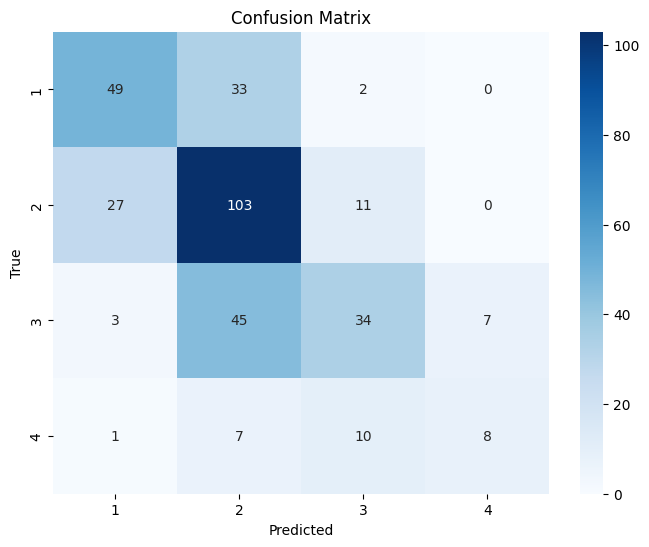

accuracy for class 1: 0.583
accuracy for class 2: 0.730
accuracy for class 3: 0.382
accuracy for class 4: 0.308

Evaluating the model on the train set...
accuracy on train set:  0.5962671905697446
precision on train set:  0.6053530084139639
recall on train set:  0.5962671905697446
f1 score on train set:  0.5839480149791744
balanced accuracy on train set:  0.5353560472441617
logistic loss on train set:  0.05011994974046824
mse on train set:  0.46954813359528486

Scorecard table:
      Feature               Bin    Points
0  pLBC Value  [0.0174, 0.1012[  1.703437
1  pLBC Value  [0.1012, 0.1707[  3.393416
2  pLBC Value     [0.1707, inf[  2.066884
3  pBCE Value  [0.0184, 0.3684[  0.789652
4  pBCE Value  [0.3684, 0.9219[  1.944111
5  pBCE Value     [0.9219, inf[  1.053658
6  cX2b Value   [0.014, 0.0267[  0.264214
7  cX2b Value  [0.0267, 0.6881[  0.269726
8  cX2b Value     [0.6881, inf[  1.654421

SBC columns weights:
            Feature    Weight
9   featsbcol1-bin1 -2.640528
10  featsbcol2-

In [13]:
# EXISTING + LR + ORDINAL
'''scorecard = Scorecard()
_,_ = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [], 
                    thresholds_method="EXISTING", 
                    encoding_method="DIFF_CODING",
                    model_method="ML", 
                    params={'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}, 
                    use_sbc=True, 
                    K=4, 
                    mapping=mapping)

scorecard.evaluate()

scorecard.show_scorecard()



accuracy:  0.5705882352941176
precision:  0.5754540763673891
recall:  0.5705882352941176
f1 score:  0.5590565661613793
balanced accuracy:  0.5008861417091157
logistic loss:  0.06532919677518614
mse:  0.5588235294117647

accuracy for class 1: 0.583
accuracy for class 2: 0.730
accuracy for class 3: 0.382
accuracy for class 4: 0.308

Evaluating the model on the train set...
accuracy on train set:  0.5962671905697446
precision on train set:  0.6053530084139639
recall on train set:  0.5962671905697446
f1 score on train set:  0.5839480149791744
balanced accuracy on train set:  0.5353560472441617
logistic loss on train set:  0.05011994974046824
mse on train set:  0.46954813359528486

Scorecard table:
      Feature               Bin    Points
0  pLBC Value  [0.0174, 0.1012[  1.703437
1  pLBC Value  [0.1012, 0.1707[  3.393416
2  pLBC Value     [0.1707, inf[  2.066884
3  pBCE Value  [0.0184, 0.3684[  0.789652
4  pBCE Value  [0.3684, 0.9219[  1.944111
5  pBCE Value     [0.9219, inf[  1.053658
6  cX2b Value   [0.014, 0.0267[  0.264214
7  cX2b Value  [0.0267, 0.6881[  0.269726
8  cX2b Value     [0.6881, inf[  1.654421

SBC columns weights:
            Feature    Weight
9   featsbcol1-bin1 -2.640528
10  featsbcol2-bin1 -5.906284'''

testing parameters: {'datafit': <skglm.datafits.single_task.Huber object at 0x160a11fd0>, 'penalty': <skglm.penalties.separable.MCPenalty object at 0x1609a5250>, 'solver': <skglm.solvers.anderson_cd.AndersonCD object at 0x1609a5f10>}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5462378054670143
testing parameters: {'datafit': <skglm.datafits.single_task.Huber object at 0x160a11fd0>, 'penalty': <skglm.penalties.separable.SCAD object at 0x1609a5790>, 'solver': <skglm.solvers.anderson_cd.AndersonCD object at 0x1609a5f10>}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.5501738626485076
best parameters:  {'datafit': <skglm.datafits.single_task.Huber object at 0x160a11fd0>, 'penalty': <skglm.penalties.separable.SCAD object at 0x1609a5790>, 'solver': <skglm.solvers.anderson_cd.AndersonCD object at 0x1609a5f10>}
best score:  0.5501738626485076

Evaluating the model on the test set...
test predictions:  [ 1.10960547  0.66346115  0.40393892 ...  0.56147623

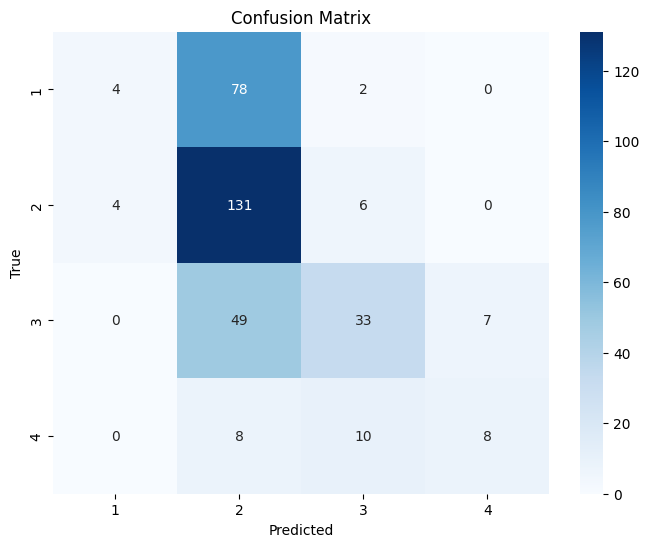

accuracy for class 1: 0.048
accuracy for class 2: 0.929
accuracy for class 3: 0.371
accuracy for class 4: 0.308

Evaluating the model on the train set...
accuracy on train set:  0.5609037328094303
precision on train set:  0.6218935416680356
recall on train set:  0.5609037328094303
f1 score on train set:  0.49291709889354546
balanced accuracy on train set:  0.45737798892505593
logistic loss on train set:  0.03449812230052774
mse on train set:  0.462671905697446

Scorecard table:
      Feature               Bin    Points
0  pLBC Value  [0.0174, 0.1012[  0.189107
1  pLBC Value  [0.1012, 0.1707[  0.359022
2  pLBC Value     [0.1707, inf[  0.124852
3  pBCE Value  [0.0184, 0.3684[  0.080920
4  pBCE Value  [0.3684, 0.9219[  0.211345
5  cX2b Value   [0.014, 0.0267[  0.059728
6  cX2b Value     [0.6881, inf[  0.177147

SBC columns weights:
            Feature    Weight
9   featsbcol1-bin1 -0.446144
10  featsbcol2-bin1 -0.705667


In [14]:
# EXISTING + skglm + ORDINAL
'''from skglm.datafits import Huber
from skglm.penalties import MCPenalty, SCAD
from skglm.solvers import AndersonCD

scorecard = Scorecard()
_,_ = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [], 
                    thresholds_method="EXISTING", 
                    encoding_method="DIFF_CODING",
                    model_method="BEYOND_L1", 
                    params={'datafit': Huber(delta=1.0), 'penalty': MCPenalty(alpha=1e-2, gamma=3), 'solver': AndersonCD()},
                    use_sbc=True, 
                    K=4, 
                    mapping=mapping)

scorecard.evaluate()

scorecard.show_scorecard()


accuracy:  0.5176470588235295
precision:  0.5379257399554249
recall:  0.5176470588235295
f1 score:  0.44168946150949767
balanced accuracy:  0.41379397158742126
logistic loss:  0.035501550533849076
mse:  0.5705882352941176
number of far off predictions:  11
number of features:  11
number of non-zero weights:  9
model size (non-zero weights / all weights):  0.8181818181818182


accuracy for class 1: 0.048
accuracy for class 2: 0.929
accuracy for class 3: 0.371
accuracy for class 4: 0.308

Evaluating the model on the train set...
accuracy on train set:  0.5609037328094303
precision on train set:  0.6218935416680356
recall on train set:  0.5609037328094303
f1 score on train set:  0.49291709889354546
balanced accuracy on train set:  0.45737798892505593
logistic loss on train set:  0.03449812230052774
mse on train set:  0.462671905697446

Scorecard table:
      Feature               Bin    Points
0  pLBC Value  [0.0174, 0.1012[  0.189107
1  pLBC Value  [0.1012, 0.1707[  0.359022
2  pLBC Value     [0.1707, inf[  0.124852
3  pBCE Value  [0.0184, 0.3684[  0.080920
4  pBCE Value  [0.3684, 0.9219[  0.211345
5  cX2b Value   [0.014, 0.0267[  0.059728
6  cX2b Value     [0.6881, inf[  0.177147

SBC columns weights:
            Feature    Weight
9   featsbcol1-bin1 -0.446144
10  featsbcol2-bin1 -0.705667'''

#### test existing thresholds on binary dataset


Evaluating the model on the test set...
test predictions:  [0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1
 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1
 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 0 1 1 1 1]
     True Value  Prediction
0             0           0
1             0           1
2             1           1
3             1           1
4             1           1
..          ...         ...
335           1           0
336           1          

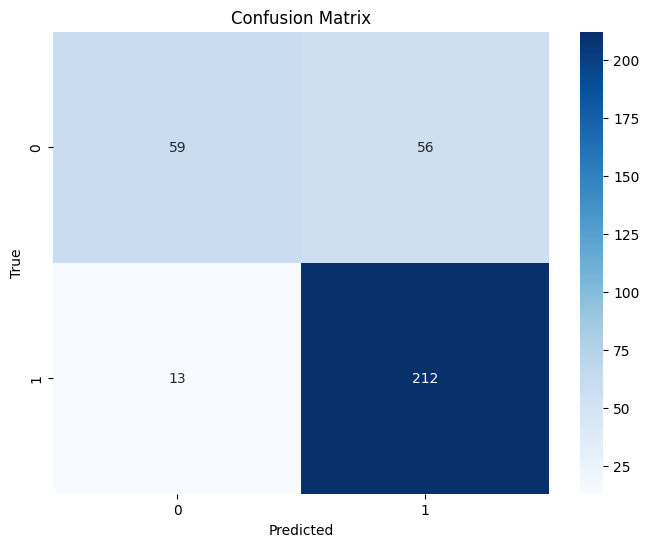

accuracy for class 0: 0.513
accuracy for class 1: 0.942

Evaluating the model on the train set...
auc on train set:  0.7528761061946904
accuracy on train set:  0.8202357563850687
precision on train set:  0.8266107796930658
recall on train set:  0.8202357563850687
f1 score on train set:  0.8078624439478751
balanced accuracy on train set:  0.7528761061946903
logistic loss on train set:  0.4513340179950768
mse on train set:  0.17976424361493124

Scorecard table:
      Feature               Bin    Points
0  pLBC Value  [0.0174, 0.1012[ -1.756404
1  pLBC Value  [0.1012, 0.1707[ -3.491347
2  pLBC Value     [0.1707, inf[ -7.422311
3  pBCE Value  [0.0184, 0.3684[ -0.731648
4  pBCE Value  [0.3684, 0.9219[ -1.802705
5  pBCE Value     [0.9219, inf[ -8.902387
6  cX2b Value   [0.014, 0.0267[ -0.183912
7  cX2b Value  [0.0267, 0.6881[ -0.360233
8  cX2b Value     [0.6881, inf[ -2.077223


In [17]:
# EXISTING + LR + BINARY
'''scorecard = Scorecard()
_,_ = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [], 
                    thresholds_method="EXISTING", 
                    encoding_method="DIFF_CODING",
                    model_method="ML", 
                    params={'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'})

scorecard.evaluate()

scorecard.show_scorecard()


auc:  0.7276328502415458
accuracy:  0.7970588235294118
precision:  0.800650546288167
recall:  0.7970588235294118
f1 score:  0.7825763903200963
balanced accuracy:  0.7276328502415459
logistic loss:  0.4562774025456949
mse:  0.20294117647058824
number of features:  9
number of non-zero weights:  9
model size (non-zero weights / all weights):  1.0

accuracy for class 0: 0.513
accuracy for class 1: 0.942

Evaluating the model on the train set...
auc on train set:  0.7528761061946904
accuracy on train set:  0.8202357563850687
precision on train set:  0.8266107796930658
recall on train set:  0.8202357563850687
f1 score on train set:  0.8078624439478751
balanced accuracy on train set:  0.7528761061946903
logistic loss on train set:  0.4513340179950768
mse on train set:  0.17976424361493124

Scorecard table:
      Feature               Bin    Points
0  pLBC Value  [0.0174, 0.1012[ -1.756404
1  pLBC Value  [0.1012, 0.1707[ -3.491347
2  pLBC Value     [0.1707, inf[ -7.422311
3  pBCE Value  [0.0184, 0.3684[ -0.731648
4  pBCE Value  [0.3684, 0.9219[ -1.802705
5  pBCE Value     [0.9219, inf[ -8.902387
6  cX2b Value   [0.014, 0.0267[ -0.183912
7  cX2b Value  [0.0267, 0.6881[ -0.360233
8  cX2b Value     [0.6881, inf[ -2.077223'''


Evaluating the model on the test set...
test predictions:  [0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1
 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1
 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 0 1 1 1 1]
     True Value  Prediction
0             0           0
1             0           1
2             1           1
3             1           1
4             1           1
..          ...         ...
335           1           0
336           1          

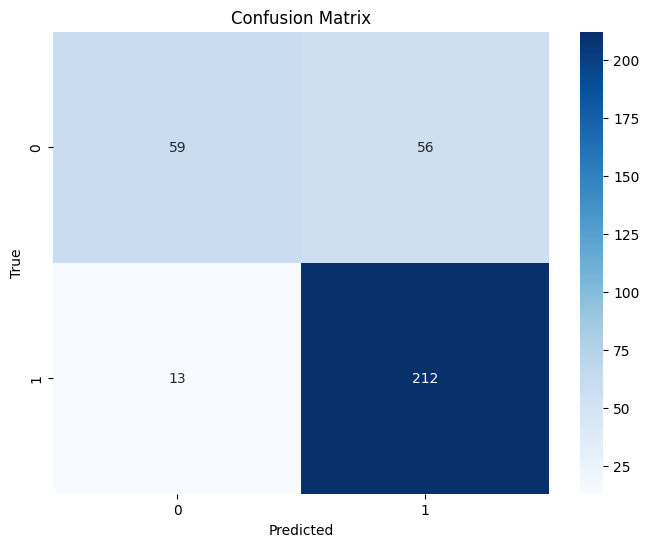

accuracy for class 0: 0.513
accuracy for class 1: 0.942

Evaluating the model on the train set...
auc on train set:  0.7528761061946904
accuracy on train set:  0.8202357563850687
precision on train set:  0.8266107796930658
recall on train set:  0.8202357563850687
f1 score on train set:  0.8078624439478751
balanced accuracy on train set:  0.7528761061946903
logistic loss on train set:  0.4513340179950768
mse on train set:  0.17976424361493124

Scorecard table:
      Feature               Bin    Points
0  pLBC Value  [0.0174, 0.1012[ -1.999787
1  pLBC Value  [0.1012, 0.1707[ -2.000293
2  pBCE Value  [0.0184, 0.3684[ -0.000032
3  pBCE Value  [0.3684, 0.9219[ -2.000048
4  pBCE Value     [0.9219, inf[ -1.999458
5  cX2b Value   [0.014, 0.0267[ -0.000286
6  cX2b Value  [0.0267, 0.6881[ -0.000043
7  cX2b Value     [0.6881, inf[ -1.999964


In [19]:
# EXISTING + SVM + BINARY
'''scorecard = Scorecard()
_,_ = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [], 
                    thresholds_method="EXISTING", 
                    encoding_method="DIFF_CODING",
                    model_method="MM",
                    params={'C': 2}
                    )

scorecard.evaluate()

scorecard.show_scorecard()


auc:  0.7276328502415458
accuracy:  0.7970588235294118
precision:  0.800650546288167
recall:  0.7970588235294118
f1 score:  0.7825763903200963
balanced accuracy:  0.7276328502415459
logistic loss:  0.4562774025456949
mse:  0.20294117647058824
number of features:  9
number of non-zero weights:  8
model size (non-zero weights / all weights):  0.8888888888888888


accuracy for class 0: 0.513
accuracy for class 1: 0.942

Evaluating the model on the train set...
auc on train set:  0.7528761061946904
accuracy on train set:  0.8202357563850687
precision on train set:  0.8266107796930658
recall on train set:  0.8202357563850687
f1 score on train set:  0.8078624439478751
balanced accuracy on train set:  0.7528761061946903
logistic loss on train set:  0.4513340179950768
mse on train set:  0.17976424361493124

Scorecard table:
      Feature               Bin    Points
0  pLBC Value  [0.0174, 0.1012[ -1.999787
1  pLBC Value  [0.1012, 0.1707[ -2.000293
2  pBCE Value  [0.0184, 0.3684[ -0.000032
3  pBCE Value  [0.3684, 0.9219[ -2.000048
4  pBCE Value     [0.9219, inf[ -1.999458
5  cX2b Value   [0.014, 0.0267[ -0.000286
6  cX2b Value  [0.0267, 0.6881[ -0.000043
7  cX2b Value     [0.6881, inf[ -1.999964'''

testing parameters: {'datafit': <skglm.datafits.single_task.Huber object at 0x16a20e910>, 'penalty': <skglm.penalties.separable.MCPenalty object at 0x173297ad0>, 'solver': <skglm.solvers.anderson_cd.AndersonCD object at 0x16a20eb90>}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.8124408384043272
testing parameters: {'datafit': <skglm.datafits.single_task.Huber object at 0x16a20e910>, 'penalty': <skglm.penalties.separable.SCAD object at 0x16a287f90>, 'solver': <skglm.solvers.anderson_cd.AndersonCD object at 0x16a20eb90>}
  fold  1
  fold  2
  fold  3
  fold  4
  fold  5
  mean score: 0.8183328503815319
best parameters:  {'datafit': <skglm.datafits.single_task.Huber object at 0x16a20e910>, 'penalty': <skglm.penalties.separable.SCAD object at 0x16a287f90>, 'solver': <skglm.solvers.anderson_cd.AndersonCD object at 0x16a20eb90>}
best score:  0.8183328503815319

Evaluating the model on the test set...
test predictions:  [ 0.13059958  0.73453174  0.73453174  0.73453174  0.

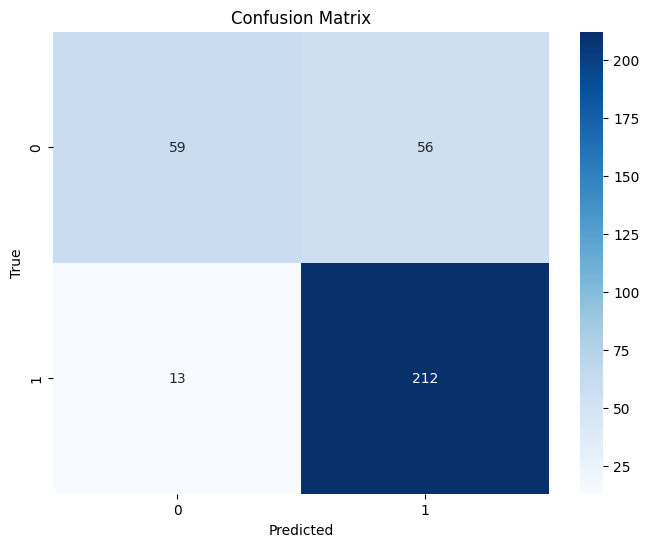

accuracy for class 0: 0.513
accuracy for class 1: 0.942

Evaluating the model on the train set...
auc on train set:  0.7499349297241021
accuracy on train set:  0.8182711198428291
precision on train set:  0.8248393011062538
recall on train set:  0.8182711198428291
f1 score on train set:  0.8054753354761712
balanced accuracy on train set:  0.749934929724102
logistic loss on train set:  0.4513340179950768
mse on train set:  0.18172888015717092

Scorecard table:
      Feature               Bin    Points
0  pLBC Value  [0.0174, 0.1012[ -0.209384
1  pLBC Value  [0.1012, 0.1707[ -0.603932
2  pBCE Value  [0.0184, 0.3684[ -0.084703
3  pBCE Value  [0.3684, 0.9219[ -0.329837
4  cX2b Value   [0.014, 0.0267[ -0.080639
5  cX2b Value     [0.6881, inf[ -0.341484


In [20]:
# EXISTING + skglm + BINARY
'''from skglm.datafits import Huber
from skglm.penalties import MCPenalty, SCAD
from skglm.solvers import AndersonCD

scorecard = Scorecard()
_,_ = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [], 
                    thresholds_method="EXISTING", 
                    encoding_method="DIFF_CODING",
                    model_method="BEYOND_L1", 
                    params={'datafit': Huber(delta=1.0), 'penalty': MCPenalty(alpha=1e-2, gamma=3), 'solver': AndersonCD()},
                    )

scorecard.evaluate()

scorecard.show_scorecard()


auc:  0.7276328502415458
accuracy:  0.7970588235294118
precision:  0.800650546288167
recall:  0.7970588235294118
f1 score:  0.7825763903200963
balanced accuracy:  0.7276328502415459
logistic loss:  0.4562774025456949
mse:  0.20294117647058824
number of features:  9
number of non-zero weights:  6
model size (non-zero weights / all weights):  0.6666666666666666


accuracy for class 0: 0.513
accuracy for class 1: 0.942

Evaluating the model on the train set...
auc on train set:  0.7499349297241021
accuracy on train set:  0.8182711198428291
precision on train set:  0.8248393011062538
recall on train set:  0.8182711198428291
f1 score on train set:  0.8054753354761712
balanced accuracy on train set:  0.749934929724102
logistic loss on train set:  0.4513340179950768
mse on train set:  0.18172888015717092

Scorecard table:
      Feature               Bin    Points
0  pLBC Value  [0.0174, 0.1012[ -0.209384
1  pLBC Value  [0.1012, 0.1707[ -0.603932
2  pBCE Value  [0.0184, 0.3684[ -0.084703
3  pBCE Value  [0.3684, 0.9219[ -0.329837
4  cX2b Value   [0.014, 0.0267[ -0.080639
5  cX2b Value     [0.6881, inf[ -0.341484'''

#### riskslim solutions

In [20]:
# solution for EXISTING + ORDINAL

''' 
+---------------------------------------------+-------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(0 + score))   |                   |           |
| =========================================== | ================= | ========= |
| featpLBC Value-bin1                         |         -1 points |   + ..... |
| featpLBC Value-bin2                         |          1 points |   + ..... |
| featpLBC Value-bin3                         |          3 points |   + ..... |
| featpBCE Value-bin1                         |          0 points |   + ..... |
| featpBCE Value-bin2                         |          0 points |   + ..... |
| featpBCE Value-bin3                         |          0 points |   + ..... |
| featcX2b Value-bin1                         |          0 points |   + ..... |
| featcX2b Value-bin2                         |          0 points |   + ..... |
| featcX2b Value-bin3                         |          0 points |   + ..... |
| featsbcol1-bin1                             |         -2 points |   + ..... |
| featsbcol2-bin1                             |         -1 points |   + ..... |
| =========================================== | ================= | ========= |
| ADD POINTS FROM ROWS 1 to 11                |             SCORE |   = ..... |
+---------------------------------------------+-------------------+-----------+
{'L0_max': 11,
 'L0_min': 0,
 'c0_value': 1e-06,
 'callback_time': 0.002474069595336914,
 'coef_set': +---------------------+-------+------+------------+-----------+-----+
|    variable_name    | vtype | sign |     lb     |     ub    |  c0 |
+---------------------+-------+------+------------+-----------+-----+
|     (Intercept)     |   C   |  0   |   -50.0    |    50.0   | 0.0 |
| featpLBC Value-bin1 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpLBC Value-bin2 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpLBC Value-bin3 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpBCE Value-bin1 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpBCE Value-bin2 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpBCE Value-bin3 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2b Value-bin1 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2b Value-bin2 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2b Value-bin3 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featsbcol1-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featsbcol2-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
+---------------------+-------+------+------------+-----------+-----+,
 'data_time': 0.0002448558807373047,
 'loss_value': 0.29084659844626914,
 'nodes_processed': 0,
 'objective_value': 0.2908575984462691,
 'optimality_gap': 0.0,
 'run_time': 0.006818056106567383,
 'solution': array([ 0.03108287, -1.23667316,  1.55110331,  3.06293898, -0.13022257,
        0.10859546,  0.74391516,  0.01040377, -0.19982142, -0.98230896,
       -2.02358663, -1.93094134]),
 'solver_time': 0.004343986511230469,
 'w_pos': 1.0}
 '''

solution = np.array([ 0.03108287, -1.23667316,  1.55110331,  3.06293898, 
                    -0.13022257, 0.10859546, 0.74391516, 0.01040377, 
                    -0.19982142, -0.98230896, -2.02358663, -1.93094134])

intercept = solution[0]
coefs = solution[1:]

'''
threshold = 0.12
Test Accuracy: 0.45588235294117646
Train Accuracy: 0.5157170923379175

threshold = 0.50
Test Accuracy: 0.2823529411764706
Train Accuracy: 0.2554027504911591
'''

'\nthreshold = 0.12\nTest Accuracy: 0.45588235294117646\nTrain Accuracy: 0.5157170923379175\n\nthreshold = 0.50\nTest Accuracy: 0.2823529411764706\nTrain Accuracy: 0.2554027504911591\n'

In [21]:
 # solution for EXISTING + BINARY
'''+---------------------------------------------+-------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(4 + score))   |                   |           |
| =========================================== | ================= | ========= |
| featpLBC Value-bin3                         |          9 points |   + ..... |
| featcX2b Value-bin1                         |          0 points |   + ..... |
| featcX2b Value-bin2                         |          0 points |   + ..... |
| featpBCE Value-bin1                         |          0 points |   + ..... |
| featpLBC Value-bin1                         |         -1 points |   + ..... |
| featpBCE Value-bin2                         |         -1 points |   + ..... |
| featcX2b Value-bin3                         |         -2 points |   + ..... |
| featpBCE Value-bin3                         |         -2 points |   + ..... |
| featpLBC Value-bin2                         |         -3 points |   + ..... |
| =========================================== | ================= | ========= |
| ADD POINTS FROM ROWS 1 to 9                 |             SCORE |   = ..... |
+---------------------------------------------+-------------------+-----------+
{'L0_max': 9,
 'L0_min': 0,
 'c0_value': 1e-06,
 'callback_time': 0.008576154708862305,
 'coef_set': +---------------------+-------+------+------------+-----------+-----+
|    variable_name    | vtype | sign |     lb     |     ub    |  c0 |
+---------------------+-------+------+------------+-----------+-----+
|     (Intercept)     |   C   |  0   |   -50.0    |    50.0   | 0.0 |
| featpLBC Value-bin1 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpLBC Value-bin2 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpLBC Value-bin3 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpBCE Value-bin1 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpBCE Value-bin2 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpBCE Value-bin3 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2b Value-bin1 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2b Value-bin2 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2b Value-bin3 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
+---------------------+-------+------+------------+-----------+-----+,
 'data_time': 0.006616115570068359,
 'loss_value': 0.639339245495578,
 'nodes_processed': 0,
 'objective_value': 0.639348245495578,
 'optimality_gap': 1.5825929489290794e-05,
 'run_time': 0.02307295799255371,
 'solution': array([ 4.13910096, -1.77992873, -3.50091623,  9.85567336, -0.72352423,
       -1.80383974, -2.98586898, -0.21783579, -0.37797319, -2.04420818]),
 'solver_time': 0.014496803283691406,
 'w_pos': 1.0}'''
 
solution = np.array([ 4.13910096, -1.77992873, -3.50091623,  9.85567336,
                     -0.72352423, -1.80383974, -2.98586898, -0.21783579,
                     -0.37797319, -2.04420818])
intercept = solution[0]
coefs = solution[1:]


'''
Best threshold: 0.44
Train accuracy: 0.7908
Test accuracy: 0.7794

threshold = 0.50
Test Accuracy: 0.7764705882352941
Train Accuracy: 0.7888015717092338
'''

'\nBest threshold: 0.44\nTrain accuracy: 0.7908\nTest accuracy: 0.7794\n\nthreshold = 0.50\nTest Accuracy: 0.7764705882352941\nTrain Accuracy: 0.7888015717092338\n'

In [22]:
# CAIM + BINARY
'''+-----------------------------------------------+-------------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(-50 + score))   |                         |           |
| ============================================= | ======================= | ========= |
| featcEMDL Value-bin1                          |          1000000 points |   + ..... |
| featpBOD Value-bin3                           |               62 points |   + ..... |
| featcEMDa Value-bin1                          |               52 points |   + ..... |
| featpBCD Value-bin3                           |               13 points |   + ..... |
| featcX2b Value-bin3                           |                8 points |   + ..... |
| featcEMDLab Value-bin2                        |                0 points |   + ..... |
| featBCD Value-bin2                            |                0 points |   + ..... |
| featBOD Value-bin2                            |                0 points |   + ..... |
| featcEMDb Value-bin2                          |                0 points |   + ..... |
| featcEMDa Value-bin2                          |                0 points |   + ..... |
| featcX2a Value-bin2                           |                0 points |   + ..... |
| featcX2Lab Value-bin2                         |                0 points |   + ..... |
| featBRA Value-bin2                            |                0 points |   + ..... |
| featLBC Value-bin2                            |                0 points |   + ..... |
| featBAD Value-bin2                            |                0 points |   + ..... |
| featpUNR Value-bin2                           |                0 points |   + ..... |
| featpBRA Value-bin2                           |                0 points |   + ..... |
| featpBAD Value-bin2                           |                0 points |   + ..... |
| featpBOD Value-bin2                           |                0 points |   + ..... |
| featUNR Value-bin2                            |                0 points |   + ..... |
| featBCE Value-bin2                            |                0 points |   + ..... |
| featcX2b Value-bin2                           |                0 points |   + ..... |
| featcEMDL Value-bin2                          |                0 points |   + ..... |
| featpBCE Value-bin2                           |                0 points |   + ..... |
| featpBCD Value-bin2                           |               -1 points |   + ..... |
| featcX2L Value-bin2                           |               -1 points |   + ..... |
| featpLBC Value-bin2                           |               -1 points |   + ..... |
| featcEMDb Value-bin3                          |               -9 points |   + ..... |
| featBOD Value-bin3                            |             -144 points |   + ..... |
| featcEMDb Value-bin1                          |         -1000000 points |   + ..... |
| featcEMDLab Value-bin3                        |         -1000000 points |   + ..... |
| ============================================= | ======================= | ========= |
| ADD POINTS FROM ROWS 1 to 31                  |                   SCORE |   = ..... |
+-----------------------------------------------+-------------------------+-----------+
{'L0_max': 66,
 'L0_min': 0,
 'c0_value': 1e-06,
 'callback_time': 0.06652641296386719,
 'coef_set': +------------------------+-------+------+------------+-----------+-----+
|     variable_name      | vtype | sign |     lb     |     ub    |  c0 |
+------------------------+-------+------+------------+-----------+-----+
|      (Intercept)       |   C   |  0   |   -50.0    |    50.0   | 0.0 |
|   featBRA Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBRA Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBRA Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featLBC Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featLBC Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featLBC Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featUNR Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featUNR Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featUNR Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBCE Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBCE Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBCE Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBCD Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBCD Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBCD Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBAD Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBAD Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBAD Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBOD Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBOD Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBOD Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBRA Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBRA Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBRA Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpLBC Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpLBC Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpLBC Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpUNR Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpUNR Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpUNR Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBCE Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBCE Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBCE Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBCD Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBCD Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBCD Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBAD Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBAD Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBAD Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBOD Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBOD Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBOD Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2L Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2L Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2L Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2a Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2a Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2a Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2b Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2b Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2b Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2Lab Value-bin1  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2Lab Value-bin2  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2Lab Value-bin3  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDL Value-bin1  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDL Value-bin2  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDL Value-bin3  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDa Value-bin1  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDa Value-bin2  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDa Value-bin3  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDb Value-bin1  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDb Value-bin2  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDb Value-bin3  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcEMDLab Value-bin1 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcEMDLab Value-bin2 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcEMDLab Value-bin3 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
+------------------------+-------+------+------------+-----------+-----+,
 'data_time': 0.05127573013305664,
 'loss_value': 0.5567300325845045,
 'nodes_processed': 0,
 'objective_value': 0.5567610325845045,
 'optimality_gap': 0.0,
 'run_time': 0.135329008102417,
 'solution': array([-5.00000000e+01,  0.00000000e+00, -1.44096000e-01,  0.00000000e+00,
        0.00000000e+00, -1.50749778e-01,  0.00000000e+00,  0.00000000e+00,
       -6.55507652e-01,  0.00000000e+00,  0.00000000e+00, -7.79942109e-01,
        0.00000000e+00,  0.00000000e+00,  1.94484557e-01,  0.00000000e+00,
        0.00000000e+00, -2.50447103e-01,  0.00000000e+00,  0.00000000e+00,
        1.22179745e-01, -1.44794611e+02,  0.00000000e+00, -3.93424342e-01,
        0.00000000e+00,  0.00000000e+00, -1.35438464e+00,  0.00000000e+00,
        0.00000000e+00, -3.75779479e-01,  0.00000000e+00,  0.00000000e+00,
       -9.91086235e-01,  0.00000000e+00,  0.00000000e+00, -1.01311800e+00,
        1.38642920e+01,  0.00000000e+00, -5.19186889e-01,  0.00000000e+00,
        0.00000000e+00, -6.33368566e-01,  6.29290941e+01,  0.00000000e+00,
       -1.14387930e+00,  0.00000000e+00,  0.00000000e+00, -1.05150910e-01,
        0.00000000e+00,  0.00000000e+00, -8.22934580e-01,  8.14220194e+00,
        0.00000000e+00, -1.16238077e-01,  0.00000000e+00,  1.00000000e+06,
       -9.50856676e-01,  0.00000000e+00,  5.24615078e+01, -7.73024799e-03,
        0.00000000e+00, -1.00000000e+06,  7.16912060e-02, -9.16609035e+00,
        0.00000000e+00,  2.23066948e-01, -1.00000000e+06]),
 'solver_time': 0.0688025951385498,
 'w_pos': 1.0}'''

solution = np.array([-5.00000000e+01,  0.00000000e+00, -1.44096000e-01,  0.00000000e+00,
                    0.00000000e+00, -1.50749778e-01,  0.00000000e+00,  0.00000000e+00,
                   -6.55507652e-01,  0.00000000e+00,  0.00000000e+00, -7.79942109e-01,
                    0.00000000e+00,  0.00000000e+00,  1.94484557e-01,  0.00000000e+00,
                    0.00000000e+00, -2.50447103e-01,  0.00000000e+00,  0.00000000e+00,
                    1.22179745e-01, -1.44794611e+02,  0.00000000e+00, -3.93424342e-01,
                    0.00000000e+00,  0.00000000e+00, -1.35438464e+00,  0.00000000e+00,
                    0.00000000e+00, -3.75779479e-01,  0.00000000e+00,  0.00000000e+00,
                   -9.91086235e-01,  0.00000000e+00,  0.00000000e+00, -1.01311800e+00,
                   1.38642920e+01,  0.00000000e+00, -5.19186889e-01,  0.00000000e+00,
                   0.00000000e+00, -6.33368566e-01,  6.29290941e+01,  0.00000000e+00,
                   -1.14387930e+00,  0.00000000e+00,  0.00000000e+00, -1.05150910e-01,
                   0.00000000e+00,  0.00000000e+00, -8.22934580e-01,  8.14220194e+00,
                   0.00000000e+00, -1.16238077e-01,  0.00000000e+00,  1.00000000e+06,
                   -9.50856676e-01,  0.00000000e+00,  5.24615078e+01, -7.73024799e-03,
                   0.00000000e+00, -1.00000000e+06,  7.16912060e-02, -9.16609035e+00,
                   0.00000000e+00,  2.23066948e-01, -1.00000000e+06])
intercept = solution[0]
coefs = solution[1:]
print(len(coefs))

''' 
Threshold = 0.50
Test Accuracy: 0.8176
Train Accuracy: 0.8301

Best threshold: 0.57
Train accuracy: 0.8379
Test accuracy: 0.7971
'''

66


' \nThreshold = 0.50\nTest Accuracy: 0.8176\nTrain Accuracy: 0.8301\n\nBest threshold: 0.57\nTrain accuracy: 0.8379\nTest accuracy: 0.7971\n'

In [ ]:
# CAIM + ORDINAL
# max model size = 42
'''+-----------------------------------------------+-------------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(-50 + score))   |                         |           |
| ============================================= | ======================= | ========= |
| featcX2Lab Value-bin3                         |          1000000 points |   + ..... |
| featcX2b Value-bin3                           |               70 points |   + ..... |
| featcX2L Value-bin1                           |               50 points |   + ..... |
| featcEMDL Value-bin2                          |                4 points |   + ..... |
| featBCE Value-bin2                            |                3 points |   + ..... |
| featpBOD Value-bin2                           |                2 points |   + ..... |
| featpLBC Value-bin2                           |                2 points |   + ..... |
| featcX2b Value-bin2                           |                1 points |   + ..... |
| featUNR Value-bin2                            |                0 points |   + ..... |
| featBCD Value-bin2                            |                0 points |   + ..... |
| featpBCE Value-bin2                           |                0 points |   + ..... |
| featBRA Value-bin2                            |                0 points |   + ..... |
| featLBC Value-bin2                            |                0 points |   + ..... |
| featBRA Value-bin3                            |                0 points |   + ..... |
| featcX2a Value-bin2                           |                0 points |   + ..... |
| featcEMDb Value-bin2                          |                0 points |   + ..... |
| featcX2L Value-bin2                           |                0 points |   + ..... |
| featBOD Value-bin2                            |               -1 points |   + ..... |
| featLBC Value-bin3                            |               -1 points |   + ..... |
| featcEMDLab Value-bin2                        |               -1 points |   + ..... |
| featsbcol1-bin1                               |               -4 points |   + ..... |
| featsbcol2-bin1                               |               -8 points |   + ..... |
| featcEMDLab Value-bin3                        |              -26 points |   + ..... |
| featcEMDL Value-bin3                          |         -1000000 points |   + ..... |
| featcEMDb Value-bin3                          |         -1000000 points |   + ..... |
| ============================================= | ======================= | ========= |
| ADD POINTS FROM ROWS 1 to 25                  |                   SCORE |   = ..... |
+-----------------------------------------------+-------------------------+-----------+
{'L0_max': 42,
 'L0_min': 0,
 'c0_value': 1e-06,
 'callback_time': 0.6106839179992676,
 'coef_set': +------------------------+-------+------+------------+-----------+-----+
|     variable_name      | vtype | sign |     lb     |     ub    |  c0 |
+------------------------+-------+------+------------+-----------+-----+
|      (Intercept)       |   C   |  0   |   -50.0    |    50.0   | 0.0 |
|   featBRA Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBRA Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBRA Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featLBC Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featLBC Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featLBC Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featUNR Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featUNR Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featUNR Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBCE Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBCE Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBCE Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBCD Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBCD Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBCD Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBAD Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBAD Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBAD Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBOD Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBOD Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featBOD Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBRA Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBRA Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBRA Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpLBC Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpLBC Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpLBC Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpUNR Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpUNR Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpUNR Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBCE Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBCE Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBCE Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBCD Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBCD Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBCD Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBAD Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBAD Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBAD Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBOD Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBOD Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featpBOD Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2L Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2L Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2L Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2a Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2a Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2a Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2b Value-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2b Value-bin2   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcX2b Value-bin3   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2Lab Value-bin1  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2Lab Value-bin2  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2Lab Value-bin3  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDL Value-bin1  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDL Value-bin2  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDL Value-bin3  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDa Value-bin1  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDa Value-bin2  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDa Value-bin3  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDb Value-bin1  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDb Value-bin2  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|  featcEMDb Value-bin3  |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcEMDLab Value-bin1 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcEMDLab Value-bin2 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcEMDLab Value-bin3 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|    featsbcol1-bin1     |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|    featsbcol2-bin1     |   C   |  0   | -1000000.0 | 1000000.0 | nan |
+------------------------+-------+------+------------+-----------+-----+,
 'data_time': 0.2437891960144043,
 'loss_value': 0.386925180584248,
 'nodes_processed': 10000,
 'objective_value': 0.386950180584248,
 'optimality_gap': 0.9998344827001142,
 'run_time': 30.003151178359985,
 'solution': array([-5.00000000e+01,  0.00000000e+00,  6.81410802e-01,  2.83978367e-01,
        0.00000000e+00,  6.40353965e-01, -1.11970687e+00,  0.00000000e+00,
        9.70938693e-01,  0.00000000e+00,  0.00000000e+00,  3.07197783e+00,
        0.00000000e+00,  0.00000000e+00,  9.43981928e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.07091274e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.27335273e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        7.64263660e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.74561105e+00,  0.00000000e+00,  5.08311841e+01,
       -9.93167432e-01,  0.00000000e+00,  0.00000000e+00, -1.17527714e-01,
        0.00000000e+00,  0.00000000e+00,  1.26803540e+00,  7.02935308e+01,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+06,  0.00000000e+00,
        4.46701129e+00, -1.00000000e+06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -9.67145536e-01, -1.00000000e+06,
        0.00000000e+00, -1.34740306e+00, -2.60833260e+01, -4.12565642e+00,
       -8.71564640e+00]),
 'solver_time': 29.392467260360718,
 'w_pos': 1.0}'''



solution = np.array([-5.00000000e+01,  0.00000000e+00,  6.81410802e-01,  2.83978367e-01,
        0.00000000e+00,  6.40353965e-01, -1.11970687e+00,  0.00000000e+00,
        9.70938693e-01,  0.00000000e+00,  0.00000000e+00,  3.07197783e+00,
        0.00000000e+00,  0.00000000e+00,  9.43981928e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.07091274e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.27335273e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        7.64263660e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.74561105e+00,  0.00000000e+00,  5.08311841e+01,
       -9.93167432e-01,  0.00000000e+00,  0.00000000e+00, -1.17527714e-01,
        0.00000000e+00,  0.00000000e+00,  1.26803540e+00,  7.02935308e+01,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+06,  0.00000000e+00,
        4.46701129e+00, -1.00000000e+06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -9.67145536e-01, -1.00000000e+06,
        0.00000000e+00, -1.34740306e+00, -2.60833260e+01, -4.12565642e+00,
       -8.71564640e+00])

intercept = solution[0]
coefs = solution[1:]

''' 
Threshold = 0.50
Test Accuracy: 0.0000
Train Accuracy: 0.0000

Best threshold: 0.41
Train accuracy: 0.5442
Test accuracy: 0.4559

Model size: 25
'''

In [ ]:
# INFINITESIMAL BINS + ORDINAL
# max model size = 5
# max absolute value = 5
''' 
setting c0_value = 0.0 for (Intercept) to ensure that intercept is not penalized
08/22/25 @ 08:03 PM | switching loss computation from fast to lookup
08/22/25 @ 08:03 PM | 223861 rows in lookup table
08/22/25 @ 08:03 PM | ------------------------------------------------------------
08/22/25 @ 08:03 PM | runnning initialization procedure
08/22/25 @ 08:03 PM | ------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/mafaldacosta/Documents/risk-slim/sbc_test.py", line 79, in <module>
    mip_objects = riskslim.setup_lattice_cpa(data, constraints, settings)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mafaldacosta/Documents/risk-slim/riskslim/lattice_cpa.py", line 136, in setup_lattice_cpa
    initial_pool, initial_cuts, initial_bounds = initialize_lattice_cpa(Z = Z,
                                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mafaldacosta/Documents/risk-slim/riskslim/initialization.py", line 63, in initialize_lattice_cpa
    cpa_stats, cuts, cpa_pool = run_standard_cpa(cpx = risk_slim_lp,
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mafaldacosta/Documents/risk-slim/riskslim/initialization.py", line 231, in run_standard_cpa
    cpx.solve()
  File "/opt/homebrew/lib/python3.11/site-packages/cplex/__init__.py", line 1312, in solve
    _proc.lpopt(self._env._e, self._lp)
  File "/opt/homebrew/lib/python3.11/site-packages/cplex/_internal/_procedural.py", line 738, in lpopt
    check_status(env, status)
  File "/opt/homebrew/lib/python3.11/site-packages/cplex/_internal/_procedural.py", line 249, in __call__
    raise CplexSolverError(error_string, env, status)
cplex.exceptions.errors.CplexSolverError: CPLEX Error  1016: Community Edition. Problem size limits exceeded. Purchase at http://ibm.biz/error1016.
'''

In [ ]:
# INFINITESIMAL BINS + BINARY
# max model size = 5
# max absolute value = 1
'''setting c0_value = 0.0 for (Intercept) to ensure that intercept is not penalized
08/22/25 @ 08:06 PM | switching loss computation from fast to weighted
08/22/25 @ 08:06 PM | ------------------------------------------------------------
08/22/25 @ 08:06 PM | runnning initialization procedure
08/22/25 @ 08:06 PM | ------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/mafaldacosta/Documents/risk-slim/sbc_test.py", line 79, in <module>
    mip_objects = riskslim.setup_lattice_cpa(data, constraints, settings)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mafaldacosta/Documents/risk-slim/riskslim/lattice_cpa.py", line 136, in setup_lattice_cpa
    initial_pool, initial_cuts, initial_bounds = initialize_lattice_cpa(Z = Z,
                                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mafaldacosta/Documents/risk-slim/riskslim/initialization.py", line 63, in initialize_lattice_cpa
    cpa_stats, cuts, cpa_pool = run_standard_cpa(cpx = risk_slim_lp,
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mafaldacosta/Documents/risk-slim/riskslim/initialization.py", line 231, in run_standard_cpa
    cpx.solve()
  File "/opt/homebrew/lib/python3.11/site-packages/cplex/__init__.py", line 1312, in solve
    _proc.lpopt(self._env._e, self._lp)
  File "/opt/homebrew/lib/python3.11/site-packages/cplex/_internal/_procedural.py", line 738, in lpopt
    check_status(env, status)
  File "/opt/homebrew/lib/python3.11/site-packages/cplex/_internal/_procedural.py", line 249, in __call__
    raise CplexSolverError(error_string, env, status)
cplex.exceptions.errors.CplexSolverError: CPLEX Error  1016: Community Edition. Problem size limits exceeded. Purchase at http://ibm.biz/error1016.'''

#### eval riskslim

In [24]:
def find_best_threshold(encoded_train_X, train_y, encoded_test_X, test_y, intercept, coefs, original_train_y, original_test_y):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_threshold = None
    best_train_acc = 0
    best_test_acc = 0

    train_scores = intercept + np.dot(encoded_train_X, coefs)
    test_scores = intercept + np.dot(encoded_test_X, coefs)

    for threshold in thresholds:
        train_probs = 1 / (1 + np.exp(-train_scores))
        test_probs = 1 / (1 + np.exp(-test_scores))

        y_pred_train = (train_probs >= threshold).astype(int)
        y_pred_test = (test_probs >= threshold).astype(int)
        
        if ordinal:
            sbc = SBC()
            y_pred_test = sbc.classif(y_pred_test, K)
            original_test_y = sbc.apply_mapping(original_test_y, mapping)
            
            sbc = SBC()
            y_pred_train = sbc.classif(y_pred_train, K)
            original_train_y = sbc.apply_mapping(original_train_y, mapping)

        train_acc = accuracy_score(original_train_y, y_pred_train)
        test_acc = accuracy_score(original_test_y, y_pred_test)
        
        if threshold == 0.50:
            print(f"Threshold = 0.50")
            print(f"Test Accuracy: {test_acc:.4f}")
            print(f"Train Accuracy: {train_acc:.4f}")

        if train_acc > best_train_acc:
            best_train_acc = train_acc
            best_test_acc = test_acc
            best_threshold = threshold

    return best_threshold, best_train_acc, best_test_acc

best_threshold, best_train_acc, best_test_acc = find_best_threshold(
    encoded_train_X, train_y, encoded_test_X, test_y, intercept, coefs, original_train_y, original_test_y
)
print(f"\nBest threshold: {best_threshold:.2f}")
print(f"Train accuracy: {best_train_acc:.4f}")
print(f"Test accuracy: {best_test_acc:.4f}")
print(f"\nModel size: {(coefs != 0).sum()}")

Threshold = 0.50
Test Accuracy: 0.0000
Train Accuracy: 0.0000

Best threshold: 0.41
Train accuracy: 0.5442
Test accuracy: 0.4559

Model size: 25


/var/folders/wk/c98ddbnx3pd7fpdy174bcjmr0000gn/T/ipykernel_4572/3574803529.py:11: RuntimeWarning: overflow encountered in exp
  train_probs = 1 / (1 + np.exp(-train_scores))
/var/folders/wk/c98ddbnx3pd7fpdy174bcjmr0000gn/T/ipykernel_4572/3574803529.py:11: RuntimeWarning: overflow encountered in exp
  train_probs = 1 / (1 + np.exp(-train_scores))
/var/folders/wk/c98ddbnx3pd7fpdy174bcjmr0000gn/T/ipykernel_4572/3574803529.py:11: RuntimeWarning: overflow encountered in exp
  train_probs = 1 / (1 + np.exp(-train_scores))
/var/folders/wk/c98ddbnx3pd7fpdy174bcjmr0000gn/T/ipykernel_4572/3574803529.py:11: RuntimeWarning: overflow encountered in exp
  train_probs = 1 / (1 + np.exp(-train_scores))
/var/folders/wk/c98ddbnx3pd7fpdy174bcjmr0000gn/T/ipykernel_4572/3574803529.py:11: RuntimeWarning: overflow encountered in exp
  train_probs = 1 / (1 + np.exp(-train_scores))
/var/folders/wk/c98ddbnx3pd7fpdy174bcjmr0000gn/T/ipykernel_4572/3574803529.py:11: RuntimeWarning: overflow encountered in exp
  tr

### ensemble of scorecards --> add column to aesthetic data of total number of points assigned by old scorecard and give that data to my scorecard

In [25]:
def old_scorecard_points(features) :    
    points = 0.0

    # 'pLBC Value'
    if (features[0]<0.0174):
        points = 0
    elif (features[0]<0.1012):
        points = 0.1538
    elif (features[0]<0.1707):
        points = 0.4379
    else:
        points = 0.5767

    # 'pBCE Value'
    if (features[1]<0.0184):
        points += 0
    elif (features[1]<0.3684):
        points += 0.0636
    elif (features[1]<0.9219):
        points += 0.1938
    else :
        points += 0.2128
    
    # 'cX2b Value' 
    if (features[2]<0.0140):
        points += 0
    elif (features[2]<0.0267):
        points += 0.0299
    elif (features[2]<0.6881):
        points += 0.0642
    else:
        points += 0.0727
    
    return points

Column indices for old scorecard: [0, 1, 2]


/var/folders/wk/c98ddbnx3pd7fpdy174bcjmr0000gn/T/ipykernel_4572/3943647280.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aesthetic_evaluation_X.loc[i, 'points'] = points



Objective Evaluation accuracy: 0.597

Evaluating the model on the test set...
test predictions:  [1 1 0 ... 0 0 0]
     True Value  Prediction
0             3           3
1             3           3
2             1           2
3             2           2
4             2           2
..          ...         ...
335           2           2
336           2           2
337           1           2
338           1           2
339           1           1

[340 rows x 2 columns]
accuracy:  0.5794117647058824
precision:  0.5999948485141183
recall:  0.5794117647058824
f1 score:  0.5695819696570603
balanced accuracy:  0.5283166361489335
logistic loss:  0.0572114047756279
mse:  0.5
number of far off predictions:  12
number of features:  27
number of non-zero weights:  21
model size (non-zero weights / all weights):  0.7777777777777778


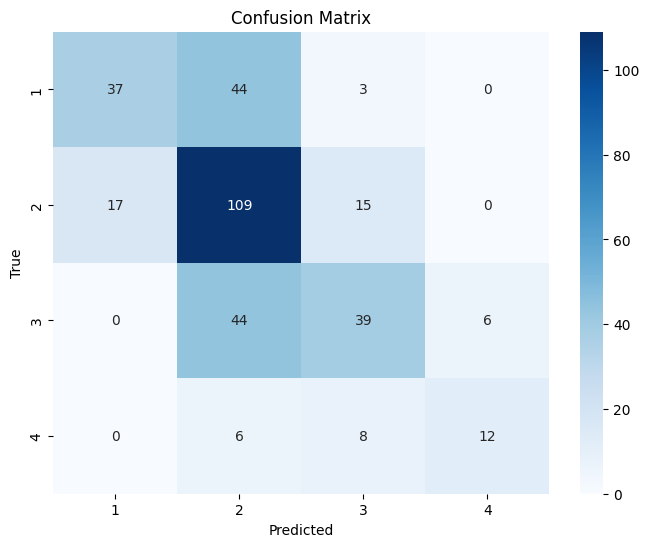

accuracy for class 1: 0.440
accuracy for class 2: 0.773
accuracy for class 3: 0.438
accuracy for class 4: 0.462

Evaluating the model on the train set...
accuracy on train set:  0.5962671905697446
precision on train set:  0.6045111919331734
recall on train set:  0.5962671905697446
f1 score on train set:  0.5820418522367582
balanced accuracy on train set:  0.5340591745809257
logistic loss on train set:  0.04434215546521338
mse on train set:  0.47544204322200395

Scorecard table:
       Feature                                        Bin    Points
0   pLBC Value   [0.0140286071627897, 0.0754687169258525[  0.630934
1   pLBC Value    [0.0754687169258525, 0.162537795701451[  1.372740
2   pLBC Value    [0.162537795701451, 0.3166823979957318[  1.401324
3   pBCE Value    [0.3034985174100497, 0.358048255463711[  0.417779
4   pBCE Value     [0.358048255463711, 0.376402851897656[  0.250183
5   pBCE Value    [0.376402851897656, 1.9451569659865504[  0.882672
6   pBCE Value                  [1.945156

In [26]:
from scorecard import Scorecard
import pandas as pd
from sklearn.metrics import accuracy_score

# load data
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')
aesthetic_evaluation_objective_evaluation = aesthetic_evaluation_data['Objective Evaluation']
aesthetic_evaluation_data = aesthetic_evaluation_data.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_X = aesthetic_evaluation_data[['pLBC Value', 'pBCE Value', 'cX2b Value', 'pUNR Value']]
aesthetic_evaluation_y = aesthetic_evaluation_data['Subjective Evaluation']

# get indices of columns used by the old scorecard
columns = ['pLBC Value', 'pBCE Value', 'cX2b Value']
column_indices = [aesthetic_evaluation_X.columns.get_loc(col) for col in columns]
print(f'Column indices for old scorecard: {column_indices}')

# add column 'points' to X, calculated by old_scorecard_points
for i in range(aesthetic_evaluation_X.shape[0]):
    features = aesthetic_evaluation_X.iloc[i].values
    points = old_scorecard_points(features)
    aesthetic_evaluation_X.loc[i, 'points'] = points
    
scorecard = Scorecard()
model, weights = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [],
                               thresholds_method='CAIM',
                               encoding_method='DIFF_CODING',
                               model_method='ML',
                               params= {'C': 2.5, 'l1_ratio': 0.4, 'penalty': 'elasticnet', 'solver': 'saga'},
                               use_sbc=True,
                               K=4,
                               mapping = {4: 'Poor', 3: 'Fair', 2: 'Good', 1: 'Excellent'}
                               )

# see accuracy of 'Objective Evaluation' on test set
test = scorecard.test_X
test_objective = aesthetic_evaluation_objective_evaluation.loc[test.index]
objective_acc = accuracy_score(test_objective, scorecard.test_y)
print(f'\nObjective Evaluation accuracy: {objective_acc:.3f}')

scorecard.evaluate()

scorecard.show_scorecard()


Evaluating the model on the test set...
test predictions:  [1 1 1 ... 0 0 0]
     True Value  Prediction
0             3           4
1             3           2
2             1           2
3             2           2
4             2           2
..          ...         ...
335           2           2
336           2           2
337           1           2
338           1           2
339           1           1

[340 rows x 2 columns]
accuracy:  0.5088235294117647
precision:  0.5460480783126934
recall:  0.5088235294117647
f1 score:  0.4684126691497601
balanced accuracy:  0.47227461756507894
logistic loss:  0.059699685175580795
mse:  0.6647058823529411
number of far off predictions:  16
number of features:  4106
number of non-zero weights:  4100
model size (non-zero weights / all weights):  0.9985387238188017


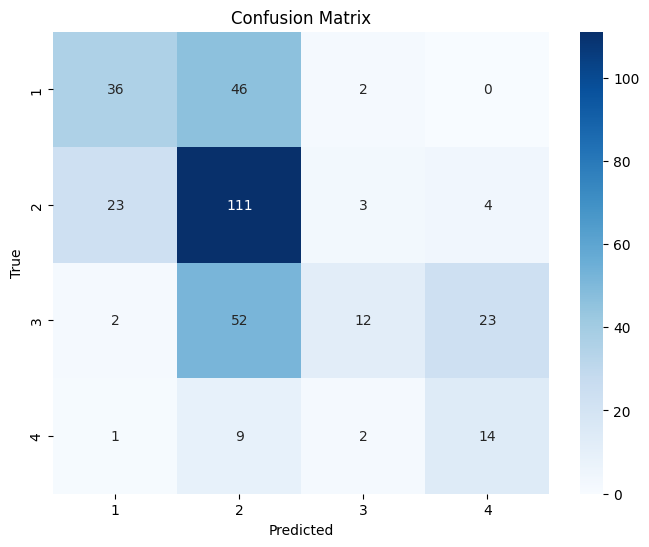

accuracy for class 1: 0.429
accuracy for class 2: 0.787
accuracy for class 3: 0.135
accuracy for class 4: 0.538

Evaluating the model on the train set...
accuracy on train set:  0.6473477406679764
precision on train set:  0.7017323704455335
recall on train set:  0.6473477406679764
f1 score on train set:  0.6057784598603058
balanced accuracy on train set:  0.6324199001207464
logistic loss on train set:  0.04800383486851113
mse on train set:  0.38212180746561886

Scorecard table:
         Feature                                             Bin    Points
0     pLBC Value  [3.2239679535846356e-05, 7.14503313927462e-05[  0.015625
1     pLBC Value  [7.14503313927462e-05, 0.00011612788529674999[ -0.009267
2     pLBC Value   [0.00011612788529674999, 0.00019454810607185[ -0.024892
3     pLBC Value        [0.00019454810607185, 0.000259873127544[ -0.032438
4     pLBC Value     [0.000259873127544, 0.00027741600466875003[ -0.016813
...          ...                                             ...   

In [27]:
scorecard = Scorecard()
model, weights = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [],
                                thresholds_method='INF_BINS',
                                encoding_method='DIFF_CODING',
                                model_method='MM',
                                params={'C': 0.015625},
                                use_sbc=True,
                                K=4,
                                mapping = {4: 'Poor', 3: 'Fair', 2: 'Good', 1: 'Excellent'}
                               )

scorecard.evaluate()

scorecard.show_scorecard()